<a href="https://colab.research.google.com/github/ShahdFekrry/Emotion-Code-Alpha_Recognition-from-Speech/blob/main/CodeAlpha_TASK2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Emotion Recognition From Speech Using Ravdess dataset**

# Import required libraries

In [270]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import IPython.display as ipd
from IPython.display import Audio

# Mount Google Drive

In [271]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Read Dataset

In [272]:
ravdess = "/content/drive/MyDrive/audio_speech_actors_01-24"
ravdess_directory_list = os.listdir(ravdess)
print(ravdess_directory_list)

['Actor_16', 'Actor_21', 'Actor_23', 'Actor_19', 'Actor_20', 'Actor_22', 'Actor_18', 'Actor_24', 'Actor_17', 'Actor_15', 'Actor_11', 'Actor_06', 'Actor_14', 'Actor_13', 'Actor_12', 'Actor_10', 'Actor_08', 'Actor_07', 'Actor_09', 'Actor_05', 'Actor_03', 'Actor_02', 'Actor_04', 'Actor_01']


# Parsing Emotion Labels and File Paths from RAVDESS Dataset

In [273]:
file_emotion = []
file_path = []

for actor_dir in ravdess_directory_list:
    actor_path = os.path.join(ravdess, actor_dir)
    actor_files = os.listdir(actor_path)

    for file_name in actor_files:
        file_parts = file_name.split('.')[0].split('-')
        emotion_label = int(file_parts[2])
        file_emotion.append(emotion_label)
        file_path.append(os.path.join(actor_path, file_name))

In [274]:
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)
ravdess_df['Emotions'].replace({1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad', 5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'}, inplace=True)

In [275]:
# Print a summary of the dataset
print(ravdess_df.head())
print(ravdess_df.tail())

  Emotions                                               Path
0  neutral  /content/drive/MyDrive/audio_speech_actors_01-...
1  neutral  /content/drive/MyDrive/audio_speech_actors_01-...
2     calm  /content/drive/MyDrive/audio_speech_actors_01-...
3     calm  /content/drive/MyDrive/audio_speech_actors_01-...
4     calm  /content/drive/MyDrive/audio_speech_actors_01-...
      Emotions                                               Path
1435   disgust  /content/drive/MyDrive/audio_speech_actors_01-...
1436   disgust  /content/drive/MyDrive/audio_speech_actors_01-...
1437      fear  /content/drive/MyDrive/audio_speech_actors_01-...
1438  surprise  /content/drive/MyDrive/audio_speech_actors_01-...
1439  surprise  /content/drive/MyDrive/audio_speech_actors_01-...


In [276]:
# Print count of emotions
print(ravdess_df['Emotions'].value_counts())

calm        192
sad         192
happy       192
angry       192
disgust     192
fear        192
surprise    192
neutral      96
Name: Emotions, dtype: int64


# Visualizations

<ipython-input-277-0c81591692ee>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=ravdess_df, x='Emotions', order=ravdess_df['Emotions'].value_counts().index, palette=colors)


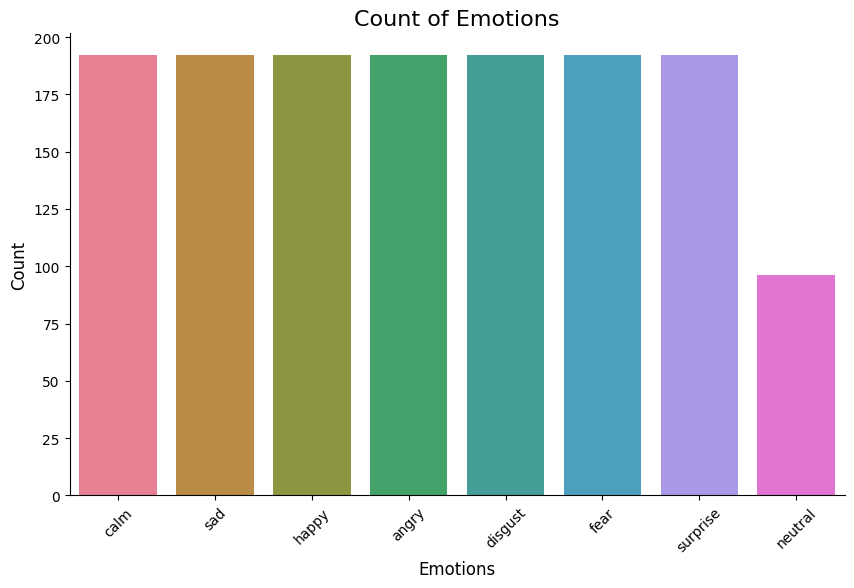

In [277]:
import matplotlib.pyplot as plt
import seaborn as sns

colors = sns.color_palette("husl", len(ravdess_df['Emotions'].unique()))

plt.figure(figsize=(10, 6))
plt.title('Count of Emotions', size=16)
sns.countplot(data=ravdess_df, x='Emotions', order=ravdess_df['Emotions'].value_counts().index, palette=colors)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.xticks(rotation=45)
plt.show()


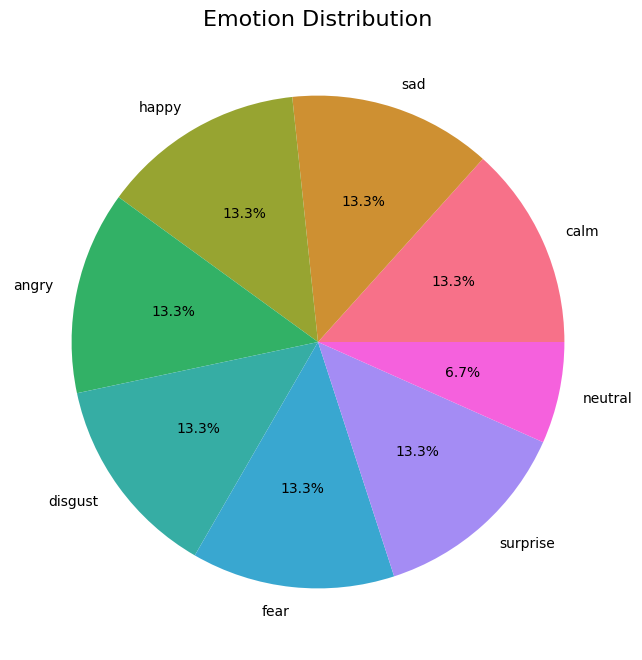

In [278]:
plt.figure(figsize=(8, 8))
plt.title('Emotion Distribution', size=16)
ravdess_df['Emotions'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=colors)
plt.ylabel('')
plt.show()


# Data Augmentation

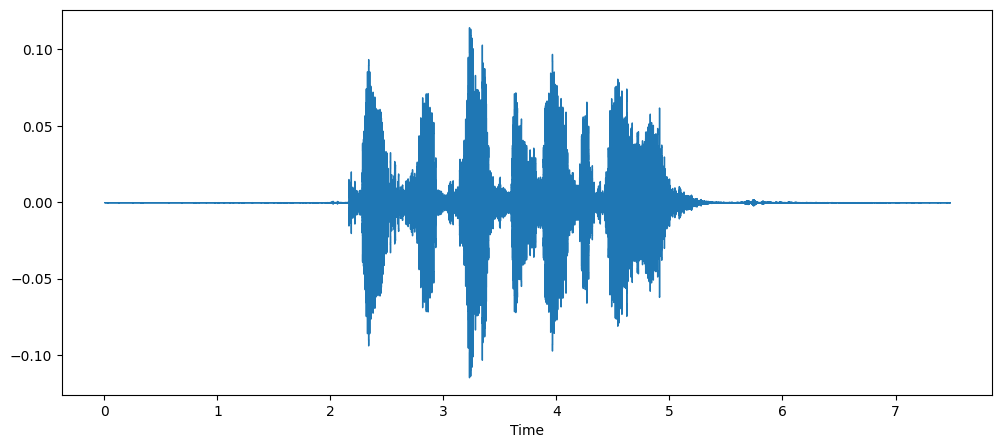

In [339]:
# NORMAL AUDIO
import librosa.display
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data, sr=sr)
ipd.Audio(data,rate=sr)

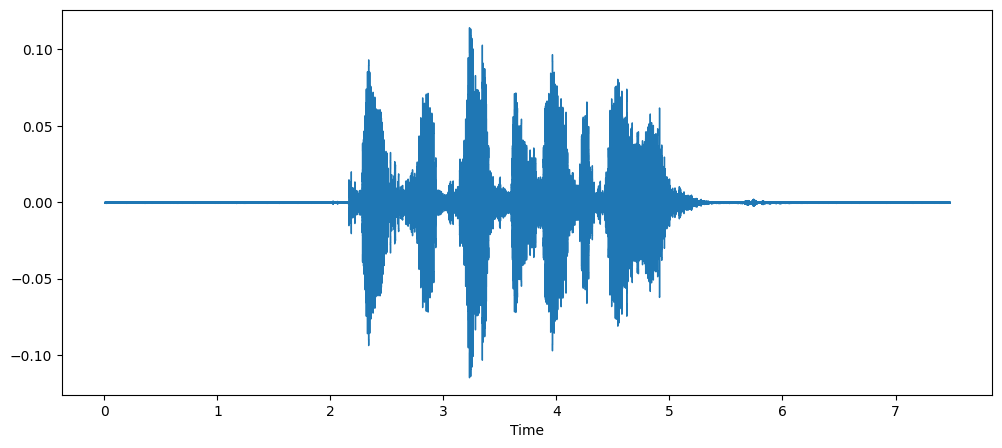

In [280]:
# Noisy Audio
def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    noisy_data = data + noise_amp * np.random.normal(size=data.shape[0])
    return noisy_data

x = noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

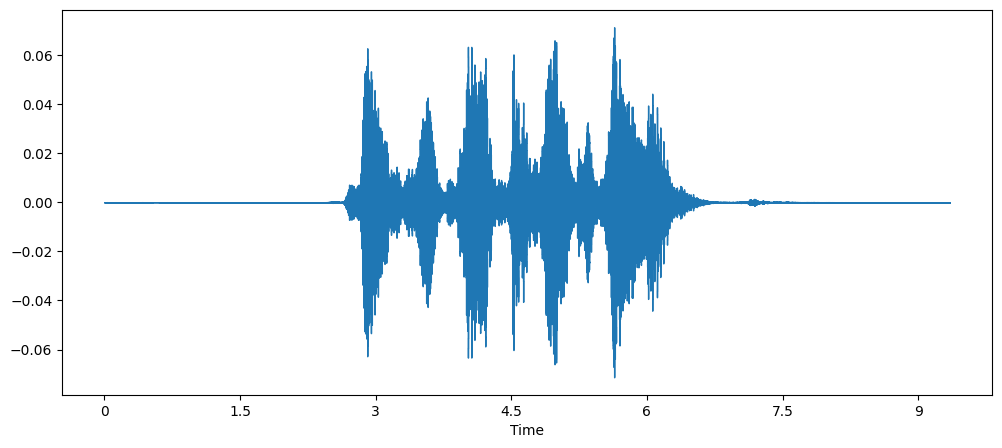

In [281]:
# STRETCHED AUDIO
def stretch(data, rate=0.8):
    stretched_data = librosa.effects.time_stretch(data, rate=rate)
    return stretched_data

x = stretch(data)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

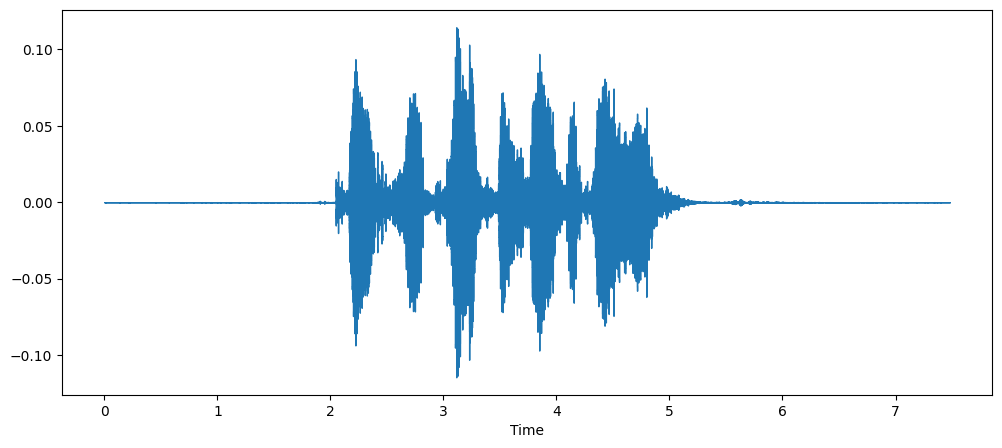

In [282]:
# SHIFTED AUDIO
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    shifted_data = np.roll(data, shift_range)
    return shifted_data

x = shift(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

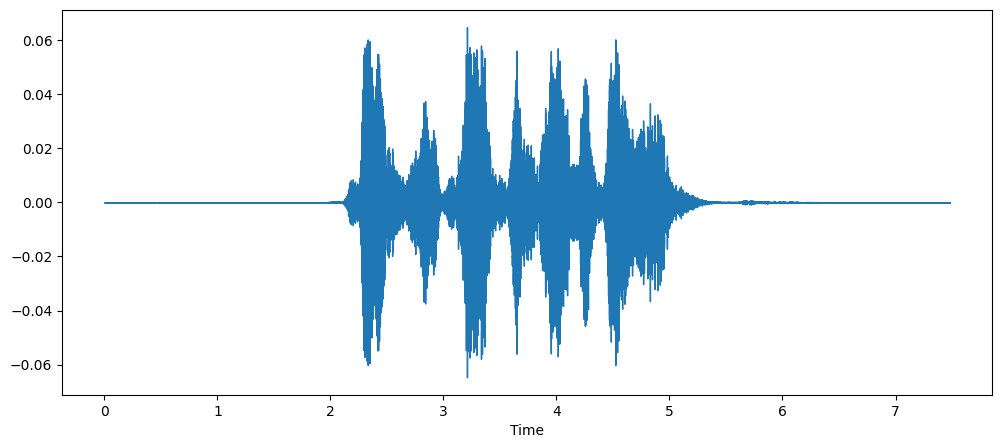

In [283]:
# AUDIO WITH PITCH
def pitch(data, sampling_rate, n_steps=3):
    pitched_data = librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=n_steps)
    return pitched_data

x = pitch(data, sr)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

# Feature Extraction

In [284]:
import librosa
import numpy as np

# Define feature extraction functions
def extract_zcr(data, frame_length, hop_length):
    zcr = librosa.feature.zero_crossing_rate(data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)

def extract_rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)

def extract_mfcc(data, sr, frame_length=2048, hop_length=512, flatten=True):
    mfccs = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=20, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(mfccs.T) if not flatten else np.ravel(mfccs.T)

# Define a function to extract features
def extract_features(data, sr=22050, frame_length=2048, hop_length=512):
    result = np.array([])

    # Extract features
    zcr_features = extract_zcr(data, frame_length, hop_length)
    rmse_features = extract_rmse(data, frame_length, hop_length)
    mfcc_features = extract_mfcc(data, sr, frame_length, hop_length)

    # Stack features
    result = np.hstack((result, zcr_features, rmse_features, mfcc_features))

    return result

# Define a function to get features from audio files
def get_features(path, duration=2.5, offset=0.6):
    data, sr = librosa.load(path, duration=duration, offset=offset)
    features = extract_features(data, sr)

    # Apply modifications and extract features for augmented data
    noised_audio = noise(data)
    features_noised = extract_features(noised_audio, sr)

    pitched_audio = pitch(data, sr)
    features_pitched = extract_features(pitched_audio, sr)

    pitched_noised_audio = noise(pitched_audio)
    features_pitched_noised = extract_features(pitched_noised_audio, sr)

    # Stack features for all augmented data
    all_features = np.vstack((features, features_noised, features_pitched, features_pitched_noised))

    return all_features


In [285]:
from joblib import Parallel, delayed

# Define a function to get features for a single audio file
def process_feature(path, emotion):
    features = get_features(path)
    X = []
    Y = []
    for ele in features:
        X.append(ele)
        # Append emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)
    return X, Y

paths = ravdess_df.Path
emotions = ravdess_df.Emotions

results = Parallel(n_jobs=-1)(delayed(process_feature)(path, emotion) for (path, emotion) in zip(paths, emotions))

# Collect the results
X = []
Y = []
for result in results:
    x, y = result
    X.extend(x)
    Y.extend(y)

# Save the extracted Features in a Dataframe

In [286]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.293457,0.365723,0.430664,0.312500,0.286621,0.297363,0.313477,0.318848,0.372559,0.376953,...,1.018233,0.266366,-0.348295,-0.518505,-0.186302,0.395265,0.914691,1.245342,1.421609,neutral
1,0.231445,0.343750,0.468262,0.461426,0.475586,0.478516,0.471680,0.474121,0.463379,0.473633,...,5.383847,1.055653,2.132447,2.919792,5.887714,3.188825,2.100356,2.474787,-0.115750,neutral
2,0.101074,0.118164,0.165039,0.157227,0.194824,0.283691,0.357910,0.388672,0.388672,0.327148,...,-0.713124,-0.942058,-1.066732,-1.124234,-1.143847,-1.142999,-1.126309,-1.088614,-1.019597,neutral
3,0.241699,0.368652,0.494141,0.494141,0.496582,0.485840,0.490723,0.491211,0.492676,0.503906,...,-0.581126,-0.479343,-0.122066,-0.681186,2.131473,3.915167,4.856527,2.823526,1.435759,neutral
4,0.091797,0.166016,0.385742,0.564941,0.622559,0.703613,0.673340,0.717285,0.793945,0.859375,...,-0.050292,-0.113112,-0.239245,-0.547270,-0.950161,-1.248004,-1.318140,-1.234907,-1.212938,neutral


In [312]:
Emotions = pd.read_csv('emotion.csv')
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.293457,0.365723,0.430664,0.312500,0.286621,0.297363,0.313477,0.318848,0.372559,0.376953,...,1.018233,0.266366,-0.348295,-0.518505,-0.186302,0.395265,0.914691,1.245342,1.421609,neutral
1,0.231445,0.343750,0.468262,0.461426,0.475586,0.478516,0.471680,0.474121,0.463379,0.473633,...,5.383847,1.055653,2.132447,2.919792,5.887714,3.188825,2.100356,2.474787,-0.115750,neutral
2,0.101074,0.118164,0.165039,0.157227,0.194824,0.283691,0.357910,0.388672,0.388672,0.327148,...,-0.713124,-0.942058,-1.066732,-1.124234,-1.143847,-1.142999,-1.126309,-1.088614,-1.019597,neutral
3,0.241699,0.368652,0.494141,0.494141,0.496582,0.485840,0.490723,0.491211,0.492676,0.503906,...,-0.581126,-0.479343,-0.122066,-0.681186,2.131473,3.915167,4.856527,2.823526,1.435759,neutral
4,0.091797,0.166016,0.385742,0.564941,0.622559,0.703613,0.673340,0.717285,0.793945,0.859375,...,-0.050292,-0.113112,-0.239245,-0.547270,-0.950161,-1.248004,-1.318140,-1.234907,-1.212938,neutral


# Preprocessing

In [313]:
Emotions.isna().sum()

0            0
1            0
2            0
3            0
4            0
            ..
2372        60
2373        60
2374        60
2375        60
Emotions     0
Length: 2377, dtype: int64

In [314]:
Emotions=Emotions.fillna(0)

In [315]:
Emotions.isna().sum()

0           0
1           0
2           0
3           0
4           0
           ..
2372        0
2373        0
2374        0
2375        0
Emotions    0
Length: 2377, dtype: int64

# Split the dataset into X and Y

In [316]:
X = Emotions.iloc[: ,:-1]
Y = Emotions['Emotions']

# One hot Encoding

In [317]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

# Split Data to training and testing

In [318]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42,test_size=0.2, shuffle=True)

# Scale the features

In [319]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Multilayer preceptron Model

In [320]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(alpha = 0.01, batch_size = 256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [321]:
model.fit(x_train, y_train)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [333]:
y_pred = model.predict(x_test)

In [334]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7439236111111112


In [338]:
from sklearn.metrics import classification_report

classification_report_str = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{classification_report_str}')

Accuracy: 0.7439236111111112
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.84      0.89       153
           1       0.97      0.85      0.91       170
           2       0.90      0.88      0.89       130
           3       0.89      0.70      0.78       148
           4       0.91      0.62      0.74       170
           5       0.95      0.72      0.82        86
           6       0.86      0.68      0.76       139
           7       0.92      0.81      0.86       156

   micro avg       0.92      0.76      0.83      1152
   macro avg       0.92      0.76      0.83      1152
weighted avg       0.92      0.76      0.83      1152
 samples avg       0.75      0.76      0.76      1152



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


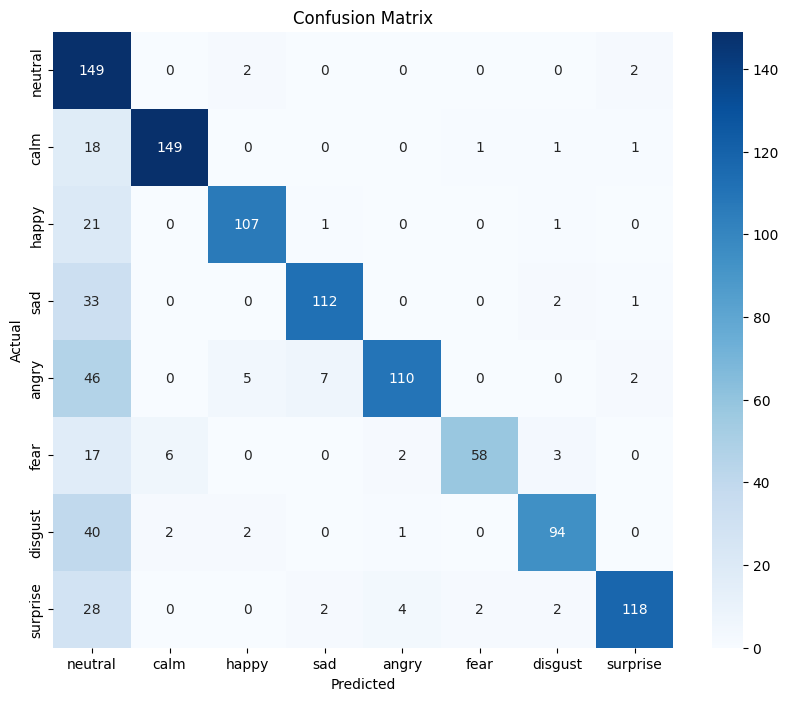

In [328]:
import seaborn as sns

# Define emotion labels
emotion_labels = {1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad', 5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'}

# Plot confusion matrix as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels.values(), yticklabels=emotion_labels.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
